## Email Classification
This program is used to classify the supporting emails in my firm, this idea is inspired by: <br />
1) the tutorial of tensorflow: https://www.tensorflow.org/tutorials/keras/basic_text_classification <br />
2) BERT. <br />
3) Google's best practice on text classification.<br />
https://github.com/google/eng-edu/tree/master/ml/guides/text_classification
https://developers.google.com/machine-learning/guides/text-classification/

In addition, the source file in this program was not uploaded, and the audience can create your own by MS excel file, in which, 2 columns, one for input question ( Data x), and one for label ( Data y).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import itertools
import os
import logging
import csv        

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding,LSTM,Flatten,GRU
from keras.preprocessing import text, sequence
from keras import utils

import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


You have TensorFlow version 1.12.0


### Load the mock dataset

In [3]:
source = pd.read_excel('../98_data/mail_translate_first_part.xlsx', encoding='latin-1')
source.head()

,Unnamed: 0,Unnamed: 0.1,convid,subject,length,tousflag,dialognm,forwardtime,imagenm,notimagenm,...,en_question,Category,Category_SAPFI,Category_SAPHR,Category_Auth,Category_Subcon,Category_Timesheet,Category_Project,Category_Report,Category_Resource
0,0,0,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,NaN,92.000000,1,4.5,0,0,0,...,Serious. Your report will be late. I\x26#39 B...,Report,NaN,NaN,NaN,NaN,NaN,NaN,Report,NaN
2,2,2,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,10月度カウンセラーデータupload完了 データ確認のお願い,38.600000,1,2.5,0,0,0,...,Good morning. I uploaded 9 uploaded counselor ...,Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,11月度カウンセラーデータupload完了,38.000000,1,1.5,0,0,0,...,Thank you for your concern. Attempting to uplo...,Report,NaN,NaN,NaN,NaN,NaN,NaN,Report,Resource
4,4,4,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,11月度カウンセラーデータupload完了 1回目,55.500000,1,1.0,0,0,0,...,Good morning. We will inform you that the firs...,Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5,AAQkADA3MWMzMjQyLWI1NzQtNGRlNi05MTMzLTA1NTU5YW...,12月度カウンセラーデータupload完了,29.888889,1,3.0,0,0,0,...,Good morning. Since the upload for December ha...,Report,NaN,NaN,NaN,NaN,NaN,NaN,Report,NaN


In [4]:
# Rename the columns
df=source[['mailquestion','Category']]
df.columns=['Emails','Cat']
df = df[pd.notnull(df['Emails'])]
df.head()

,Emails,Cat
0,大変 。 ご 連絡 が 遅く なり 。 失礼 し まし た 。 説明 が 多い 為 。 電話...,Report
2,お疲れさま です 。 10 月 分 カウンセラー データ 9 件 の upload 完了 し...,Others
3,担当 者 様 お疲れさま です 。 今月 分 の カウンセラー データ upload を 試...,Report
4,お疲れさま です 。 11 月 分 1 回 目 の カウンセラー データ upload が ...,Others
5,お疲れさま です 。 12 月 分 の upload 完了 し まし た ので 。 ご 報告...,Report


In [5]:
df.isnull().sum()

Emails    0
Cat       0
dtype: int64

In [6]:
df['Cat'].value_counts()

Others       1054
Auth          328
Subcon        285
Report        274
Project       149
Timesheet      74
Resource       55
SAPHR          33
SAPFI          31
Name: Cat, dtype: int64

Median words per sample: 112.0


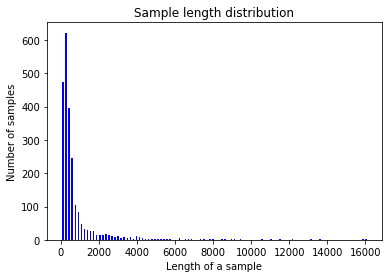

In [7]:
from google_text_classification.explore_data import get_num_words_per_sample,plot_sample_length_distribution

print("Median words per sample:",get_num_words_per_sample(df['Emails']))

plot_sample_length_distribution(df['Emails'])

In [8]:
# Split data into train, validation, and test
trans_narrative,test_narrative,trans_product, test_product = train_test_split(df['Emails'], df['Cat'],
                                                                              random_state=42, train_size=0.8
                                                                              )
train_narrative,dev_narrative,train_product, dev_product = train_test_split(trans_narrative, 
                                                                            trans_product,random_state=42,
                                                                            train_size=0.8)
print ("Train size: %d" % train_product.shape[0])
print ("Validation size: %d" % dev_product.shape[0])
print ("Test size: %d" % test_product.shape[0])

Train size: 1460
Validation size: 366
Test size: 457


In [9]:
# Create the training, dev, test set for BERT:

with open('train.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(train_narrative.shape[0]):
        tsv_output.writerow([str(1000+i),train_product.iloc[i],'',train_narrative.iloc[i]])

with open('dev.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(dev_narrative.shape[0]):
        tsv_output.writerow([str(4000+i),dev_product.iloc[i],'',dev_narrative.iloc[i]])

with open('test.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(test_narrative.shape[0]+1):
        if i==0:
            tsv_output.writerow(['index','sentence','label'])
        else:
            tsv_output.writerow([str(6000+i),test_narrative.iloc[i-1],test_product.iloc[i-1]])


### Convert the words to integers

In [10]:
# Find out the maximum words for the dimension of word vectors
def text2word(doc):
    """
    Usage: Convert one text into word list.
    Input: doc - string list
    Output: documents - string list: all sentences in words list.
            text_len - int: maximum numbers of words in one sentense
            max_text - strig list: the words list of the sentence with maximum words
    """
    return_docs=[]
    text_len=0
    max_text=''
    #for item in df['Emails']:
    for item in doc:
        text_words=[word for word in str(item).lower().split()]
        return_docs.append(text_words)
        if len(text_words)> text_len:
            text_len=len(text_words)
            max_text=text_words
    #max_words = text_len
    
    return return_docs,text_len,max_text

documents,max_words,_=text2word(df['Emails'])
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [11]:
tokenize.fit_on_texts(train_narrative) # only fit on train
x_train_o = tokenize.texts_to_matrix(train_narrative)
x_test_o = tokenize.texts_to_matrix(test_narrative)
word_index = tokenize.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7943 unique tokens.


In [12]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_product)
y_train_o = encoder.transform(train_product)
y_test_o = encoder.transform(test_product)

In [13]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train_o) + 1
y_train_o = utils.to_categorical(y_train_o, num_classes)
y_test_o = utils.to_categorical(y_test_o, num_classes)

In [14]:
print(encoder.classes_)

['Auth' 'Others' 'Project' 'Report' 'Resource' 'SAPFI' 'SAPHR' 'Subcon'
 'Timesheet']


In [15]:
encoder_t = LabelEncoder()
encoder_t.fit(test_product)
print(encoder_t.classes_)

['Auth' 'Others' 'Project' 'Report' 'Resource' 'SAPFI' 'SAPHR' 'Subcon'
 'Timesheet']


In [16]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train_o.shape)
print('x_test shape:', x_test_o.shape)
print('y_train shape:', y_train_o.shape)
print('y_test shape:', y_test_o.shape)

x_train shape: (1460, 5485)
x_test shape: (457, 5485)
y_train shape: (1460, 9)
y_test shape: (457, 9)


## 1.  Model without embedding layer

### Build the model

In [17]:
# Open questions: why are those parameters used for?
batch_size = 5
epochs = 50

In [18]:
# Build the model
model = Sequential()
model.add(Dense(16, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a categorical classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the categorical_crossentropy loss function.
This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, categorical_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.
Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.
Now, configure the model to use an optimizer and a loss function:

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                87776     
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
_________________________________________________________________
activation_2 (Activation)    (None, 9)                 0         
Total params: 87,929
Trainable params: 87,929
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [20]:
history = model.fit(x_train_o, y_train_o,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 1168 samples, validate on 292 samples
Epoch 1/50
1168/1168 [==============================] - 1s 682us/step - loss: 1.8646 - acc: 0.4418 - val_loss: 1.5093 - val_acc: 0.5034
Epoch 2/50
1168/1168 [==============================] - 0s 364us/step - loss: 1.5999 - acc: 0.4966 - val_loss: 1.3707 - val_acc: 0.4966
Epoch 3/50
1168/1168 [==============================] - 0s 363us/step - loss: 1.4417 - acc: 0.5077 - val_loss: 1.2964 - val_acc: 0.5171
Epoch 4/50
1168/1168 [==============================] - 0s 366us/step - loss: 1.3495 - acc: 0.5180 - val_loss: 1.2346 - val_acc: 0.5788
Epoch 5/50
1168/1168 [==============================] - 0s 368us/step - loss: 1.2973 - acc: 0.5402 - val_loss: 1.1778 - val_acc: 0.5616
Epoch 6/50
1168/1168 [==============================] - 0s 366us/step - loss: 1.2844 - acc: 0.5394 - val_loss: 1.1811 - val_acc: 0.5548
Epoch 7/50
1168/1168 [==============================] - 0s 349us/step - loss: 1.2125 - acc: 0.5471 - val_loss: 1.1435 - val_acc: 0.5788
E

In [21]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test_o, y_test_o,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

457/457 [==============================] - 0s 186us/step
Test score: 1.0159998761858848
Test accuracy: 0.7002188299560442


### Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

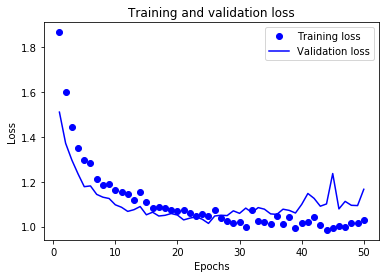

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

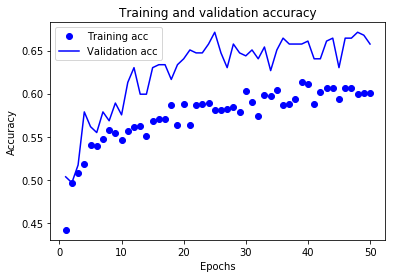

In [24]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.
Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.
This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.
For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

### Evaluate model

#### Scenario 1: Verify 10 records in test dataset

In [22]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test_o[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_narrative.iloc[i][:50], "...")
    print('Actual label:' + test_product.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

do you have user guide as to what i need to do . f ...
Actual label:Timesheet
Predicted label: Timesheet

as you know there s still missing approver data as ...
Actual label:non-issue
Predicted label: non-issue

we already assigned cheng shin aik staff as 2nd ap ...
Actual label:Authorization
Predicted label: Timesheet

when i click on choose button to select timesheet  ...
Actual label:Timesheet
Predicted label: Timesheet

you must be busy now but there s timesheet missing ...
Actual label:Timesheet
Predicted label: Timesheet

i would like to inform the problem that i couldn t ...
Actual label:Authorization
Predicted label: Timesheet

sorry to bother you please approve my timesheet kh ...
Actual label:Timesheet
Predicted label: Timesheet

could you please set up your browser according to  ...
Actual label:non-issue
Predicted label: non-issue

i d like to check why 0 hour charged following sta ...
Actual label:non-issue
Predicted label: non-issue

i d like to check why 0 hour charged a

#### Scenario 2: Predict category based on manual input

In [23]:
input_sentence = ''
while(1):
    try:
        # Get input sentence
        input_sentence = input('> ')
        # Check if it is quit case
        if input_sentence == 'q' or input_sentence == 'quit': 
            break
        # Normalize sentence
        input_sentence = tokenize.texts_to_matrix([input_sentence])       
        pred_output = model.predict(np.array(input_sentence))
        pred_prob=model.predict_proba(np.array(input_sentence))
        predicted_label = text_labels[np.argmax(pred_output)]
        print('Bot:', ' '.join([predicted_label,'Probality:',str(pred_prob[0,np.argmax(pred_output)])]))
    except KeyError:
        print("Error: Encountered unknown word.")

> I have assigned mr. li with accessing timesheet
Bot: Timesheet Probality: 0.6140563
> quit


In [24]:
encoder.classes_

array(['Authorization', 'Others', 'Project', 'Report', 'Timesheet',
       'non-issue'], dtype=object)

## 2. Model with pre-trained embedding layer - Glove

In [25]:
MAX_SEQUENCE_LENGTH = max_words
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [26]:
embeddings_index = {}
f = open(os.path.join('../98_data/glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [71]:
#leverage embedding_index dictionary and word_index to compute our embedding matrix:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [72]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [73]:
# Build the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.8))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 925, 100)          238700    
_________________________________________________________________
flatten_3 (Flatten)          (None, 92500)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                1480016   
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 102       
_________________________________________________________________
activation_15 (Activation)   (None, 6)                 0         
Total params: 1,718,818
Trainable params: 1,480,118
Non-trainable params: 238,700
____________________________________________________________

In [30]:
batch_size = 5
epochs = 50
history = model.fit(x_train_o, y_train_o,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 468 samples, validate on 118 samples
Epoch 1/50
468/468 [==============================] - 1s 3ms/step - loss: 1.5297 - acc: 0.4103 - val_loss: 1.0540 - val_acc: 0.6780
Epoch 2/50
468/468 [==============================] - 1s 2ms/step - loss: 1.3488 - acc: 0.5128 - val_loss: 0.9750 - val_acc: 0.7373
Epoch 3/50
468/468 [==============================] - 1s 2ms/step - loss: 1.2051 - acc: 0.5491 - val_loss: 0.9446 - val_acc: 0.6441
Epoch 4/50
468/468 [==============================] - 1s 2ms/step - loss: 1.2005 - acc: 0.5620 - val_loss: 0.9322 - val_acc: 0.6780
Epoch 5/50
468/468 [==============================] - 1s 2ms/step - loss: 1.1051 - acc: 0.5919 - val_loss: 0.8734 - val_acc: 0.7288
Epoch 6/50
468/468 [==============================] - 1s 2ms/step - loss: 1.0878 - acc: 0.5726 - val_loss: 0.8583 - val_acc: 0.7119
Epoch 7/50
468/468 [==============================] - 1s 2ms/step - loss: 1.0054 - acc: 0.5833 - val_loss: 0.8322 - val_acc: 0.6949
Epoch 8/50
468/468 [==========

In [31]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test_o, y_test_o,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

147/147 [==============================] - 0s 469us/step
Test score: 0.8581229376346886
Test accuracy: 0.7346938909316549


In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

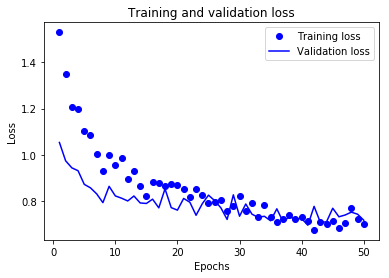

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

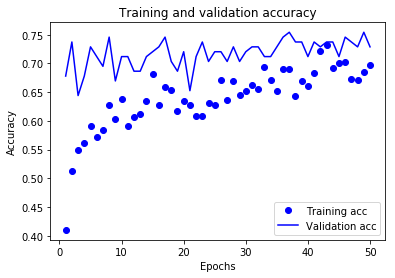

In [34]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 3. Model with pre-trained embedding layer - Word2Vec and FastText

In [35]:
# training the model of word2vec by mail body
source_text=pd.DataFrame(data=pd.concat([source['mailbody'],source['mailquestion']]),columns=['mailbody'])
mb_sen,_,_=text2word(source_text['mailbody'])
model_embedding_w = Word2Vec(sentences=mb_sen, size=EMBEDDING_DIM, window=5, min_count=2, workers=4, sg=0)
#model_embedding_w = FastText(mb_sen, size=EMBEDDING_DIM, window=5, min_count=1, workers=4,sg=1)
model_embedding_w.train(mb_sen, total_examples=len(mb_sen), epochs=50)

(5628839, 9105250)

In [36]:
#leverage embedding_index dictionary and word_index to compute our embedding matrix:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = model_embedding_w.wv.get_vector(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    except: 
        print(word, 'not found')

k not found
jan not found
aug not found
sep not found
planed not found
away not found
tuk not found
advanced not found
high not found
priority not found
mavis not found
hey not found
jingwen not found
09 not found
tentative not found
property not found
fills not found
oct not found
joins not found
fontarial not found
boldarial not found
boldarialred not found
layout not found
width not found
bgsilver not found
bgsilverred not found
bgwhite not found
bgwhitered not found
bgyellow not found
ffff00 not found
hoiday not found
comp not found
y not found


In [37]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [38]:
# Build the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.8))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
batch_size = 5
epochs = 50
history = model.fit(x_train_o, y_train_o,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 468 samples, validate on 118 samples
Epoch 1/50
468/468 [==============================] - 2s 3ms/step - loss: 1.5079 - acc: 0.4252 - val_loss: 1.0031 - val_acc: 0.6017
Epoch 2/50
468/468 [==============================] - 1s 2ms/step - loss: 1.2661 - acc: 0.5192 - val_loss: 0.9473 - val_acc: 0.6186
Epoch 3/50
468/468 [==============================] - 1s 2ms/step - loss: 1.2180 - acc: 0.5897 - val_loss: 0.9390 - val_acc: 0.6017
Epoch 4/50
468/468 [==============================] - 1s 3ms/step - loss: 1.2424 - acc: 0.5556 - val_loss: 0.8838 - val_acc: 0.6186
Epoch 5/50
468/468 [==============================] - 1s 2ms/step - loss: 1.0831 - acc: 0.6026 - val_loss: 0.8485 - val_acc: 0.6441
Epoch 6/50
468/468 [==============================] - 1s 2ms/step - loss: 1.0958 - acc: 0.6346 - val_loss: 0.8541 - val_acc: 0.6271
Epoch 7/50
468/468 [==============================] - 1s 3ms/step - loss: 1.0673 - acc: 0.6218 - val_loss: 0.9172 - val_acc: 0.6186
Epoch 8/50
468/468 [==========

In [40]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test_o, y_test_o,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

147/147 [==============================] - 0s 431us/step
Test score: 0.892202361100385
Test accuracy: 0.7006802844757937


In [41]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

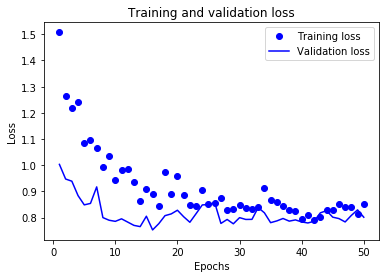

In [42]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

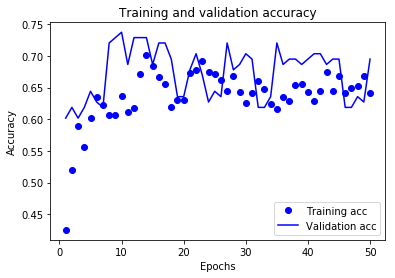

In [43]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. LSTM, GRU with simple embedding layer

In [66]:
# Open questions: why are those parameters used for?
batch_size = 5
epochs = 20
timesteps=10
# Build the model
model = Sequential()
model.add(Embedding(max_words, 512))
model.add(LSTM(512, dropout=0.8, recurrent_dropout=0.8))
#model.add(GRU(128,dropout=0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

ValueError: Input 0 is incompatible with layer lstm_9: expected ndim=3, found ndim=2

In [67]:
history = model.fit(x_train_o, y_train_o,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)


RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [46]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test_o, y_test_o,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

147/147 [==============================] - 3s 20ms/step
Test score: 1.1128758954353073
Test accuracy: 0.4761904878478472


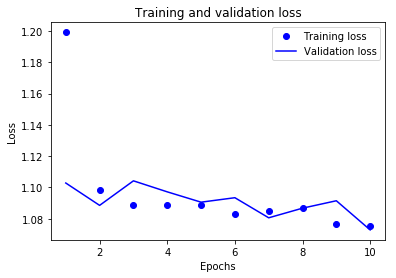

In [47]:
history_dict = history.history
history_dict.keys()
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

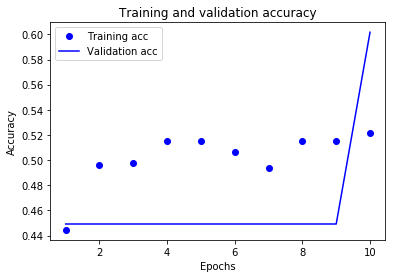

In [48]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 5. BERT

Steps to execute BERT:

1. Manually copy train.tsv, dev.tsv, test.tsv to the following GLUE_DIR:
2. Under the BERT folder, run the following command:
<pre><code>
 export BERT_BASE_DIR=/Users/patrick/documents/github/bert/multilingual_L-12_H-768_A-12
 export GLUE_DIR=/Users/patrick/documents/github/bert/glue_data
 
 python3 run_classifier.py \
  --task_name=BB-8 \
  --do_train=true \
  --do_eval=true \
  --data_dir=$GLUE_DIR/BB-8 \
  --vocab_file=$BERT_BASE_DIR/vocab.txt \
  --bert_config_file=$BERT_BASE_DIR/bert_config.json \
  --init_checkpoint=$BERT_BASE_DIR/bert_model.ckpt \
  —max_seq_length=128 \
  —train_batch_size=32 \
  --learning_rate=2e-5 \
  —num_train_epochs=3.0 \
  --output_dir=./tmp/BB-8_output/test_20181206
</code></pre>

3. After completing the above steps, run the following command:

<pre><code>
export BERT_BASE_DIR=/Users/patrick/documents/github/bert/multilingual_L-12_H-768_A-12
export GLUE_DIR=/Users/patrick/documents/github/bert/glue_data
export TRAINED_CLASSIFIER=/Users/patrick/documents/github/bert/tmp/BB-8_output/test_20181206
 
python3 run_classifier.py \
  --task_name=BB-8 \
  --do_predict=true \
  --data_dir=$GLUE_DIR/BB-8 \
  --vocab_file=$BERT_BASE_DIR/vocab.txt \
  --bert_config_file=$BERT_BASE_DIR/bert_config.json \
  --init_checkpoint=$TRAINED_CLASSIFIER \
  —max_seq_length=128 \
  --output_dir=./tmp/BB-8_output/
</code></pre>

In [25]:
## After running the above step no,3, the file "test_results.tsv" is produced, which can be used to compare the result
test_result_pd=pd.read_csv('/Users/patrick/documents/github/bert/tmp/BB-8_output/test_results.tsv', sep='\t',header=None)
test_result_pd.columns=['Auth','Others','Project','Report','Resource','SAPFI','SAPHR','Subcon','Timesheet']

In [26]:
prediction=pd.DataFrame(test_result_pd.idxmax(axis=1),columns=['prediction'])

In [27]:
x=0
for i in range(test_product.shape[0]):
    if prediction.iloc[i][0]==test_product.iloc[i]:
        x +=1
print("Test Accuracy is:",x/i)

Test Accuracy is: 0.5570175438596491


## 6. Google Best Practice

In [28]:
def convert_cat(label_set,encoder=encoder):
    """
    usage: convert label types into numbers.
    parameters: 
             label_set: label categories' set
             encoder: encoder of label categories
    return: number list of label categories
    """
    train_label=[]
    for label in label_set:
        x=0
        for items in encoder.classes_:
            if label == items:
                train_label.append(x)
                continue
            x +=1
    return np.array(train_label)

y_train_cat=convert_cat(train_product,encoder)
y_dev_cat=convert_cat(dev_product,encoder)
y_test_cat=convert_cat(test_product,encoder)

total_train=pd.concat([train_narrative,dev_narrative])

data=((total_train, np.concatenate((y_train_cat,y_dev_cat))),
            (test_narrative, y_test_cat))

In [29]:
from google_text_classification.train_sequence_model import train_sequence_model

train_sequence_model(data)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1826 samples, validate on 457 samples
Epoch 1/1000
 - 9s - loss: 2.1615 - acc: 0.3516 - val_loss: 2.1235 - val_acc: 0.4551
Epoch 2/1000
 - 8s - loss: 2.0844 - acc: 0.4633 - val_loss: 2.0357 - val_acc: 0.4551
Epoch 3/1000
 - 7s - loss: 1.9747 - acc: 0.4633 - val_loss: 1.8897 - val_acc: 0.4551
Epoch 4/1000
 - 8s - loss: 1.7915 - acc: 0.4633 - val_loss: 1.6875 - val_acc: 0.4551
Epoch 5/1000
 - 8s - loss: 1.6605 - acc: 0.4633 - val_loss: 1.6650 - val_acc: 0.4551
Epoch 6/1000
 - 7s - loss: 1.6276 - acc: 0.4633 - val_loss: 1.6461 - val_acc: 0.4551
Epoch 7/1000
 - 7s - loss: 1.5976 - acc: 0.4633 - val_loss: 1.6377 - val_acc: 0.4551
Epoch 8/1000
 - 7s - loss: 1.5826 - acc: 0.4633 - val_loss: 1.6506 - val_acc: 0.4551
Epoch 9/1000
 - 7s - loss: 1.5824 - acc: 0.4633 - val_loss: 1.6276 - val_acc: 0.4551
Epoch 10/1000
 - 7s - loss: 1.5725 - acc: 0.4633 - val_loss: 1.6200 - val_acc: 0.4551
Epoch 11/1000
 - 7s - loss: 1.5652 - acc: 0.4633 - val_loss: 1.6145 - val_acc: 0.4551
Epoch 12/1000
 -

(0.6520787785298454, 1.0909074271012187)

In [30]:
from google_text_classification.train_fine_tuned_sequence_model import train_fine_tuned_sequence_model
train_fine_tuned_sequence_model(data, '../98_data/')

Train on 1826 samples, validate on 457 samples
Epoch 1/1000
 - 6s - loss: 2.1518 - acc: 0.4294 - val_loss: 2.1089 - val_acc: 0.4551
Epoch 2/1000
 - 5s - loss: 2.0699 - acc: 0.4633 - val_loss: 2.0175 - val_acc: 0.4551
Epoch 3/1000
 - 5s - loss: 1.9545 - acc: 0.4633 - val_loss: 1.8731 - val_acc: 0.4551
Epoch 4/1000
 - 5s - loss: 1.7833 - acc: 0.4633 - val_loss: 1.6953 - val_acc: 0.4551
Epoch 5/1000
 - 5s - loss: 1.6727 - acc: 0.4633 - val_loss: 1.6815 - val_acc: 0.4551
Epoch 6/1000
 - 5s - loss: 1.6569 - acc: 0.4633 - val_loss: 1.6770 - val_acc: 0.4551
Epoch 7/1000
 - 6s - loss: 1.6488 - acc: 0.4633 - val_loss: 1.6767 - val_acc: 0.4551
Epoch 8/1000
 - 6s - loss: 1.6428 - acc: 0.4633 - val_loss: 1.6745 - val_acc: 0.4551
Epoch 9/1000
 - 6s - loss: 1.6419 - acc: 0.4633 - val_loss: 1.6652 - val_acc: 0.4551
Epoch 10/1000
 - 6s - loss: 1.6214 - acc: 0.4633 - val_loss: 1.6399 - val_acc: 0.4551
Epoch 11/1000
 - 6s - loss: 1.5843 - acc: 0.4633 - val_loss: 1.6175 - val_acc: 0.4551
Epoch 12/1000
 -

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1826 samples, validate on 457 samples
Epoch 1/1000
 - 9s - loss: 1.5072 - acc: 0.4803 - val_loss: 1.5280 - val_acc: 0.4639
Epoch 2/1000
 - 7s - loss: 1.4119 - acc: 0.5126 - val_loss: 1.4150 - val_acc: 0.4967
Epoch 3/1000
 - 7s - loss: 1.2869 - acc: 0.5285 - val_loss: 1.3057 - val_acc: 0.5142
Epoch 4/1000
 - 8s - loss: 1.1928 - acc: 0.5646 - val_loss: 1.2525 - val_acc: 0.5449
Epoch 5/1000
 - 8s - loss: 1.1039 - acc: 0.5843 - val_loss: 1.2405 - val_acc: 0.5449
Epoch 6/1000
 - 7s - loss: 1.0457 - acc: 0.6068 - val_loss: 1.2082 - val_acc: 0.5646
Epoch 7/1000
 - 8s - loss: 0.9800 - acc: 0.6265 - val_loss: 1.2022 - val_acc: 0.5536
Epoch 8/1000
 - 7s - loss: 0.9396 - acc: 0.6462 - val_loss: 1.2182 - val_acc: 0.5580
Epoch 9/1000
 - 7s - loss: 0.9024 - acc: 0.6583 - val_loss: 1.2182 - val_acc: 0.5842
Validation accuracy: 0.5842450758038777, loss: 1.2181828914116457


(0.5842450758038777, 1.2181828914116457)